## SEP Tutorial

In this notebook I will:

1. Load the sample `image.fits`
2. Display the raw image
3. Estimate the background and RMS maps
4. Subtract the background
5. Detect objects using SEP
6. Plot ellipses around detections
7. Perform simple aperture photometry

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import sep

from matplotlib import rcParams
rcParams['figure.figsize'] = [10., 8.]

from astropy.io import fits

import warnings
warnings.filterwarnings("ignore")

## Loading the FITS Image

To start, I load the FITS file using `astropy.io.fits.getdata()`.  
SEP requires floating-point input, so I convert the data to `float32` before using it.

In [66]:
data = fits.getdata("image.fits").astype(np.float32)
data.shape, data.dtype

((256, 256), dtype('float32'))

## Displaying the Raw Image

Here I display the raw FITS image using Matplotlib.  
To improve contrast, I show pixel values within one standard deviation of the mean.  
This makes faint objects easier to see.

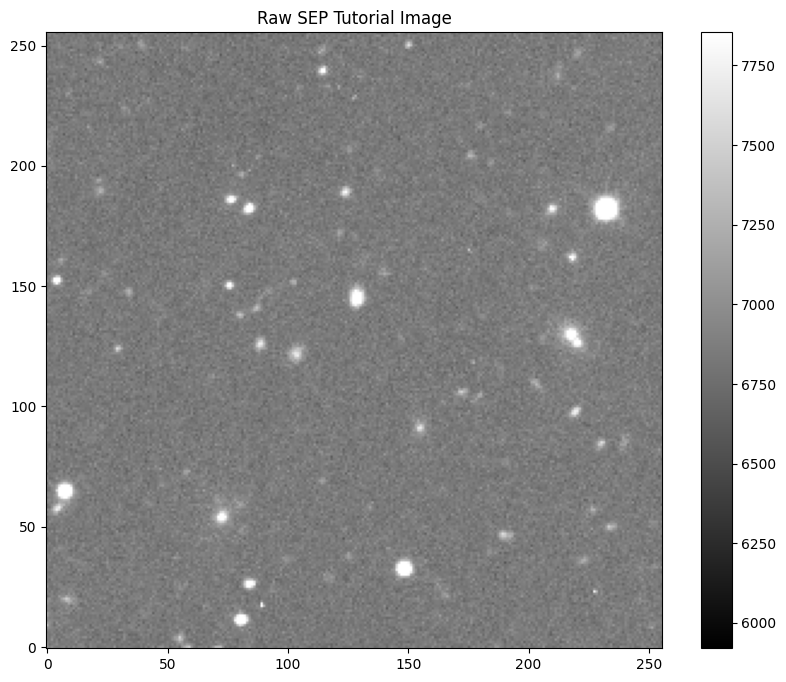

In [67]:
m, s = np.mean(data), np.std(data)

fig, ax = plt.subplots()
im = ax.imshow(data, cmap="gray", origin="lower", vmin=m - s, vmax=m + s)

fig.colorbar(im, ax=ax)
ax.set_title("Raw SEP Tutorial Image")

fig.savefig("tutorial_01_raw_image.png", dpi=200, bbox_inches="tight")
plt.show()

## Background Estimation

SEP does a smooth 2D background model for the image to remove sky noise and instrumental effects among other things.  

I will look at:
- the background (`bkg.back()`)
- the RMS noise map (`bkg.rms()`)

In [68]:
bkg = sep.Background(data)

print("Global background:", bkg.globalback)
print("Global RMS:", bkg.globalrms)

Global background: 6852.04931640625
Global RMS: 65.46174621582031


## Background Map

This is the background image that SEP estimated from the raw data.  
It shows the large-scale variations that I want to remove before detecting sources.

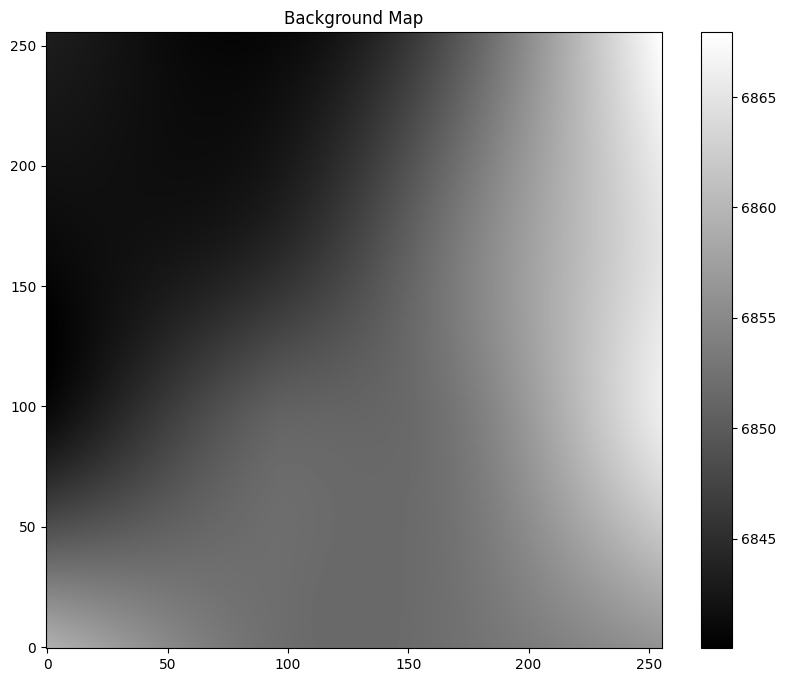

In [69]:
bkg_image = bkg.back()

fig, ax = plt.subplots()
im = ax.imshow(
    bkg_image,
    cmap="gray",
    origin="lower"
)
fig.colorbar(im, ax=ax)
ax.set_title("Background Map")

fig.savefig("tutorial_02_background.png", dpi=200, bbox_inches="tight")
plt.show()

## RMS Map

Here I plot the RMS (noise) map from SEP.  
This tells me how the noise varies across the image and is used when detecting sources.

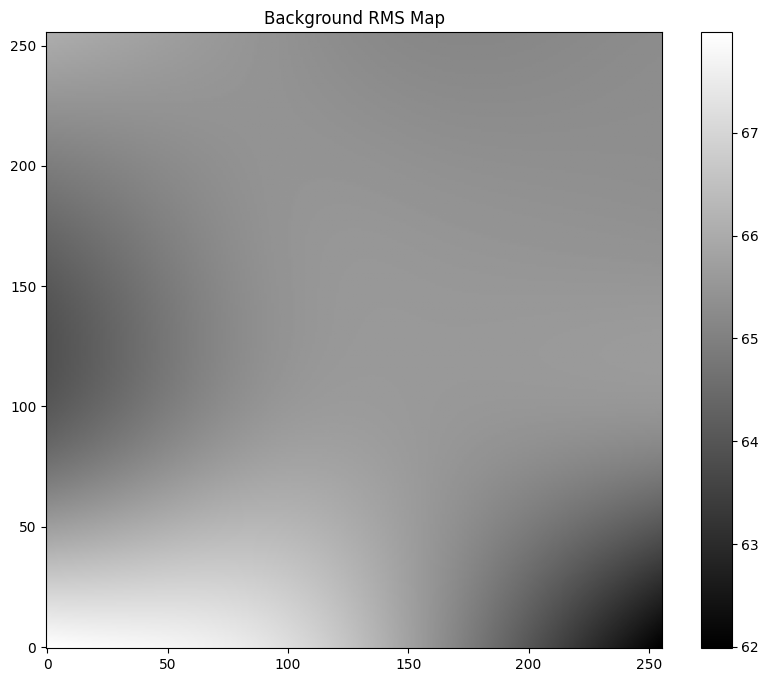

In [70]:
bkg_rms = bkg.rms()

fig, ax = plt.subplots()
im = ax.imshow(
    bkg_rms,
    cmap="gray",
    origin="lower"
)
fig.colorbar(im, ax=ax)
ax.set_title("Background RMS Map")

fig.savefig("tutorial_03_background_rms.png", dpi=200, bbox_inches="tight")
plt.show()

## Background Subtraction and Object Detection

Next, I subtract the background model from the raw data.  
I then run `sep.extract()` to detect objects that rise above the local noise.

I use a threshold of 1.5 times the RMS, similar to the SEP tutorial.

In [71]:
data_sub = data - bkg

objects = sep.extract(data_sub, thresh=1.5, err=bkg.globalrms)

print("Number of detected objects:", len(objects))
print("Object fields:", objects.dtype.names)

Number of detected objects: 68
Object fields: ('thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx', 'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak', 'xpeak', 'ypeak', 'flag')


## Visualizing the Detected Objects

SEP fits an ellipse to each detected object using its second-order moments.
In this plot, I draw a red ellipse around every detected source to visualize their sizes and orientations.

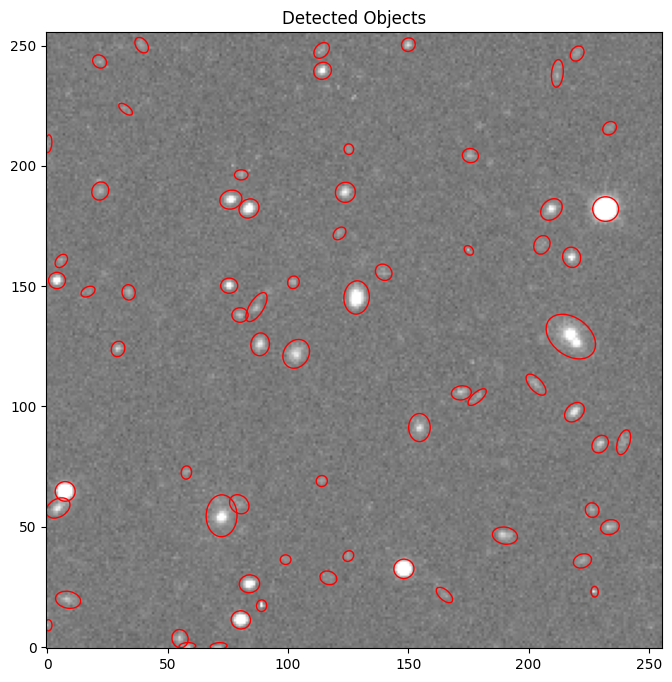

In [72]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
m, s =np.mean(data_sub), np.std(data_sub)

ax.imshow(data_sub, cmap="gray", origin="lower", vmin = m-s, vmax=m+s)

for obj in objects:
    e= Ellipse(xy=(obj['x'], obj['y']), width=6 * obj['a'], height=6 * obj['b'], angle=obj['theta'] * 180.0 / np.pi)
    e.set_facecolor("none")
    e.set_edgecolor("red")
    ax.add_patch(e)

ax.set_title("Detected Objects")

fig.savefig("tutorial_04_detections.png", dpi=200, bbox_inches="tight")
plt.show()

## Aperture Photometry

Finally, I measure the flux of each detected object using circular aperture photometry.  
I use a radius of 3 pixels, matching the SEP tutorial.  


In [73]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.157852 +/- 291.027799
object 1: flux = 3092.217500 +/- 291.592199
object 2: flux = 5949.861113 +/- 356.561993
object 3: flux = 1851.419824 +/- 295.028805
object 4: flux = 72736.380312 +/- 440.172199
object 5: flux = 3860.756895 +/- 352.163163
object 6: flux = 6418.902715 +/- 357.458957
object 7: flux = 2210.714238 +/- 350.791233
object 8: flux = 2741.609297 +/- 352.277749
object 9: flux = 20916.877363 +/- 376.966141
